In [119]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [120]:
#Retrieve pickle object
fileObj = open('data_algos.pkl', 'rb')
all_generations = pickle.load(fileObj)
fileObj.close()

In [121]:
#creating one DataFrame for each selection method
random_df = pd.DataFrame(all_generations[0])
ranked_df = pd.DataFrame(all_generations[1])
wheel_df = pd.DataFrame(all_generations[2])
#concatenating all dataframes (same dimensionality)
generations_df = pd.concat([random_df, ranked_df,wheel_df], ignore_index=True)
#checking the results
generations_df.sample(5)

,radius,generation,fitness,selection_type
44455,4.823529,144,0.006304,Ranked Selection
49677,4.823529,196,0.006304,Ranked Selection
3502,1.294118,35,0.017579,Random Selection
14140,3.411765,141,0.011023,Random Selection
37741,4.941176,77,0.006041,Ranked Selection


In [122]:
#Sample Statistics
generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])


radius                                            \
                             count       mean       std       min        50%   
selection_type   generation                                                    
Random Selection 0           100.0  14.128235  8.636377  0.117647  13.294118   
                 1           100.0  14.144706  8.600003  0.235294  13.882353   
                 2           100.0  15.256471  8.367296  0.235294  15.176471   
                 3           100.0  14.903529  8.435573  0.117647  15.058824   
                 4           100.0  15.538824  7.984741  1.411765  15.470588   
...                            ...        ...       ...       ...        ...   
Wheel Selection  295         100.0   1.529412  0.000000  1.529412   1.529412   
                 296         100.0   1.529412  0.000000  1.529412   1.529412   
                 297         100.0   1.529412  0.000000  1.529412   1.529412   
                 298         100.0   1.529412  0.000000  1.529412   1.529412   
                 299         100.0   1.529412  0.000000  1.529412   1.529412   

                                       fitness                          \
                                   max   count      mean           std   
selection_type   generation                                              
Random Selection 0           29.882353   100.0  0.003255  5.127532e-03   
                 1           29.529412   100.0  0.003167  4.648879e-03   
                 2           29.529412   100.0  0.002629  4.449149e-03   
                 3           29.882353   100.0  0.002722  4.219704e-03   
                 4           29.882353   100.0  0.002511  4.236203e-03   
...                                ...     ...       ...           ...   
Wheel Selection  295          1.529412   100.0  0.018543  6.973851e-18   
                 296          1.529412   100.0  0.018543  6.973851e-18   
                 297          1.529412   100.0  0.018543  6.973851e-18   
                 298          1.529412   100.0  0.018543  6.973851e-18   
                 299          1.529412   100.0  0.018543  6.973851e-18   

                                                           
                                  min       50%       max  
selection_type   generation                                
Random Selection 0           0.000178  0.000897  0.018701  
                 1           0.000182  0.000823  0.018668  
                 2           0.000182  0.000689  0.018668  
                 3           0.000178  0.000700  0.018668  
                 4           0.000178  0.000663  0.018668  
...                               ...       ...       ...  
Wheel Selection  295         0.018543  0.018543  0.018543  
                 296         0.018543  0.018543  0.018543  
                 297         0.018543  0.018543  0.018543  
                 298         0.018543  0.018543  0.018543  
                 299         0.018543  0.018543  0.018543  

[900 rows x 12 columns]

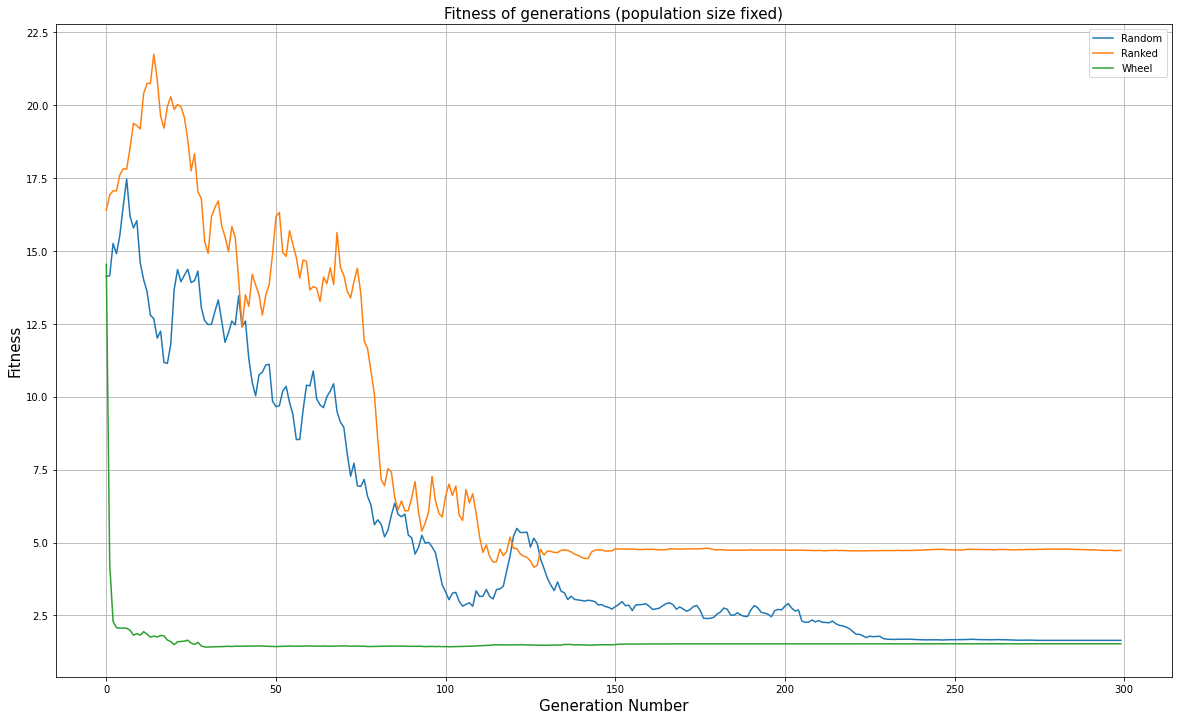

In [123]:
grouped = generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()

plt.show()

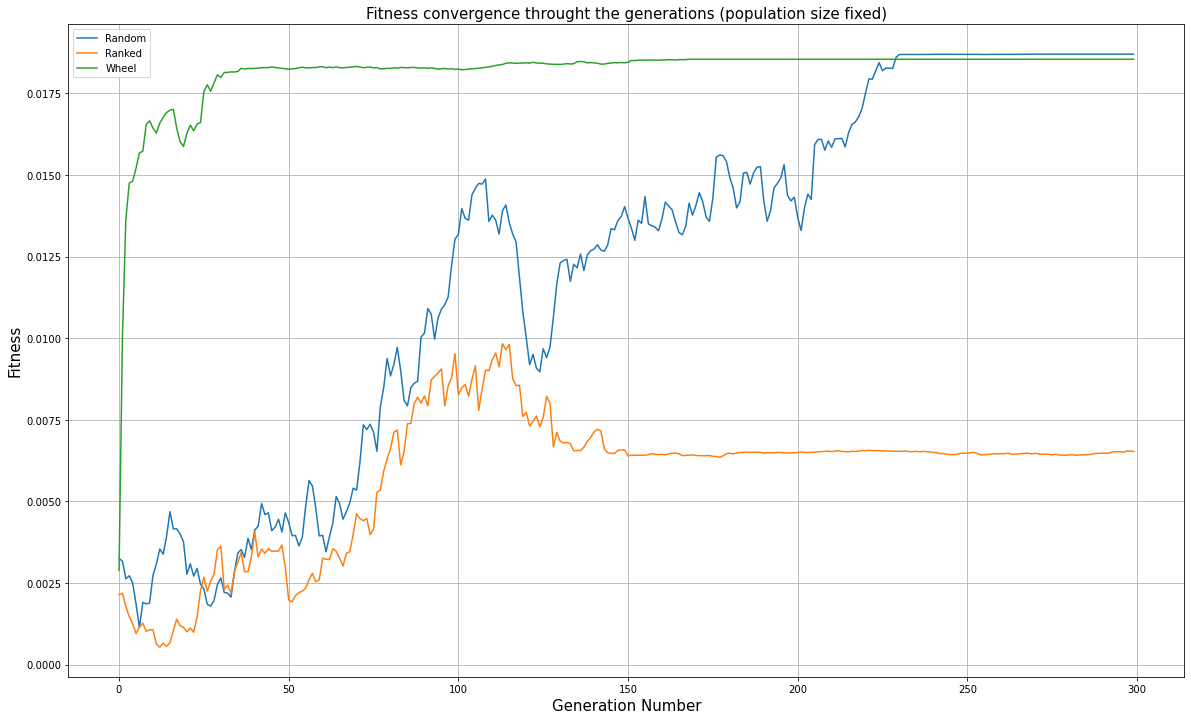

In [124]:
grouped = generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()

plt.show()